##이미지 데이터 전처리

In [ ]:
#텐서플로에서 사용 못하는 파일 형식 검출 코드
from pathlib import Path
import imghdr

data_dir = "데이터 셋 경로"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

##데이터 셋에서 89478485 픽셀을 초과하는 이미지를 확인

In [ ]:
import os

image_extensions = {".jpg", ".jpeg", ".png", ".bmp"}

dataset_dir = "데이터셋 경로"

for root, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        try:
            ext = os.path.splitext(filename)[-1].lower()  # 파일 확장자 추출
            if ext in image_extensions:
                filepath = os.path.join(root, filename)
                with Image.open(filepath) as img:
                    img_size = img.size[0] * img.size[1]
                    if img_size > 89478485:
                        print(f"Image {filename} has size {img_size} which exceeds limit of 89478485 pixels.")
            else:
                continue
        except:
            continue


In [ ]:
import os
from PIL import Image
#데이터셋에서 89478485 픽셀을 초과하는 이미지를 확인
dataset_dir = "데이터셋 경로"

for root, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        try:
            filepath = os.path.join(root, filename)
            with Image.open(filepath) as img:
                img_size = img.size[0] * img.size[1]
                if img_size > 89478485:
                    print(f"Image {filename} has size {img_size} which exceeds limit of 89478485 pixels.")
        except:
            print(f"Could not open image {filename}.")

참고)
https://github.com/LeanManager/PyTorch_Image_Classifier/blob/master/Image_Classifier_Project.ipynb

In [ ]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
# 경로설정
data_dir = "데이터 셋 경로"
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [ ]:
# Define transforms for the training, validation, and testing sets
# 훈련, 유효성 검사 및 테스트 세트에 대한 변환을 정의합니다.
training_transforms = transforms.Compose([transforms.RandomRotation(30), #주어진 각도(degrees)에 랜덤하게 회전
                                          transforms.RandomResizedCrop(224), #랜덤하게 Crop한 후에 주어진 크기만큼 Resize
                                          transforms.RandomHorizontalFlip(), #수평으로 뒤집는다. 좌우반전
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224), #가운데 기준으로 224*224 크기로 이미지 자르기
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

In [ ]:
#클래스의 수 파악
print(len(training_dataset.classes))

In [ ]:
# Build and train your network
# Transfer Learning
# 네트워크 구축 및 교육
# 이전 학습
model = models.vgg16(pretrained=True)
model

In [ ]:
# Freeze pretrained model parameters to avoid backpropogating through them
# 사전 학습된 모델 매개변수를 고정하여 백프로그래밍을 방지합니다.
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(4096, 128)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
# Function for the validation pass
# 유효성 검사 통과 함수
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# Loss function and gradient descent
# 손실 함수 및 기울기 하강
criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
%%writefile workspace_utils.py
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:
    from workspace_utils import active session
    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:
    from workspace_utils import keep_awake
    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable

Writing workspace_utils.py


In [ ]:
# Train the classifier
from workspace_utils import active_session

def train_classifier():

    with active_session():

        epochs = 15
        steps = 0
        print_every = 40

        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()
        
                if steps % print_every == 0:
                
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
                    running_loss = 0
                    model.train()
                    
train_classifier()    

Epoch: 1/15..  Training Loss: 4.596..  Validation Loss: 2.486..  Validation Accuracy: 0.352
Epoch: 1/15..  Training Loss: 2.727..  Validation Loss: 2.195..  Validation Accuracy: 0.425
Epoch: 1/15..  Training Loss: 2.505..  Validation Loss: 1.918..  Validation Accuracy: 0.511
Epoch: 1/15..  Training Loss: 2.343..  Validation Loss: 1.827..  Validation Accuracy: 0.512
Epoch: 1/15..  Training Loss: 2.305..  Validation Loss: 1.873..  Validation Accuracy: 0.507
Epoch: 1/15..  Training Loss: 2.235..  Validation Loss: 1.684..  Validation Accuracy: 0.544
Epoch: 1/15..  Training Loss: 2.274..  Validation Loss: 1.684..  Validation Accuracy: 0.557
Epoch: 1/15..  Training Loss: 2.199..  Validation Loss: 1.651..  Validation Accuracy: 0.554
Epoch: 1/15..  Training Loss: 2.122..  Validation Loss: 1.560..  Validation Accuracy: 0.583
Epoch: 1/15..  Training Loss: 2.096..  Validation Loss: 1.559..  Validation Accuracy: 0.587
Epoch: 2/15..  Training Loss: 0.755..  Validation Loss: 1.652..  Validation Accu

In [ ]:
#NVIDIA 그래픽 카드에서 현재 실행 중인 프로세스와 해당 프로세스에서 사용하는 메모리 및 GPU 사용률 등의 정보를 제공하는 코드
!nvidia-smi

In [ ]:
#테스트 함수 정의 및  테스트
def test_accuracy(model, test_loader):

    # Do validation on the test set
    # 테스트 세트에서 유효성 검사 수행
    model.eval() # PyTorch 모델을 평가(evaluation) 모드로 설정하는 메소드(평가 모드에서는 모델이 학습 중에 사용되는 데이터 증강이나 랜덤 크롭과 같은 기술을 사용하지 않도록 주의)
    model.to('cuda') # 모델의 모든 파라미터와 버퍼가 CUDA 메모리로 이동 ->  GPU에서 실행 목적

    with torch.no_grad(): # 모델을 평가할 때 사용하는 컨텍스트 매니저->계산 그래프를 생성하지 않고 모델의 출력값을 계산만 해서 정확도나 손실 등을 계산 -> 효율적!
    
        accuracy = 0 # accuracy 변수를 0으로 초기화
    
        for images, labels in iter(test_loader): # 테스트 데이터셋에서 배치(batch) 단위로 데이터를 불러오는 루프
    
            images, labels = images.to('cuda'), labels.to('cuda') # 이미지와 라벨 데이터를 CUDA로 전송하는 코드 -> GPU를 사용하여 모델의 연산 속도를 높이기 위한 것
    
            output = model.forward(images) #  입력 이미지를 받아서 출력값(output)을 계산

            probabilities = torch.exp(output) #  torch.exp() 함수를 사용하여 모델의 출력값(output)을 확률값으로 변환
        
            equality = (labels.data == probabilities.max(dim=1)[1]) # 예측값과 실제값을 비교하여 일치하는 개수를 세는 코드
            # labels.data는 실제값, probabilities.max(dim=1)[1]은 모델의 출력값 중 가장 큰 값을 가지는 인덱스를 의미. 두 값이 일치하면 equality 변수는 True
        
            accuracy += equality.type(torch.FloatTensor).mean() # 일치하는 개수를 누적하고, 평균값을 계산하여 정확도를 계산
            # equality 변수는 True 또는 False 값을 가지므로, torch.FloatTensor 타입으로 형변환한 후, mean() 함수를 사용하여 평균값을 계산

        print("Test Accuracy: {}".format(accuracy/len(test_loader)))  # 계산된 정확도를 출력
        
        
test_accuracy(model, test_loader)

In [ ]:
# 체크 포인트 저장
# Save the checkpoint - > 모델을 다시 학습할 필요 없이 이어서 학습(시간과 노력 절약)

def save_checkpoint(model): # 학습된 모델의 체크포인트를 저장하는 함수

    model.class_to_idx = training_dataset.class_to_idx # 모델에서 사용한 클래스의 인덱스 저장

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 } # 체크포인트를 저장하기 위한 딕셔너리를 생성하는 코드

    torch.save(checkpoint, 'checkpoint.pth') # 체크포인트를 파일로 저장
    
save_checkpoint(model)   

##체크포인트 파일 저장 완료

In [ ]:
from collections import OrderedDict # OrderedDict는 dict와 거의 같지만, 딕셔너리에 추가된 순서를 기억

# Function that loads a checkpoint and rebuilds the model
# 체크포인트를 로드하고 모델을 리빌드하는 함수입니다.

def load_checkpoint(filepath): # 체크포인트 파일에서 저장된 모델 정보를 로드하고, 해당 모델을 반환하는 함수
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)  # checkpoint 딕셔너리에 저장된 모델 아키텍처가 "vgg16"인 경우에 대해서만 처리 진행
        
        for param in model.parameters():
            param.requires_grad = False # 해당 모델의 모든 파라미터를 학습하지 않도록 requires_grad 속성을 False로 설정
    else:
        print("아키텍처가 인식되지 않음.")  # "vgg16"이 아닌 경우 "Architecture not recognized."라는 문구를 출력
    
    model.class_to_idx = checkpoint['class_to_idx']
                                                                    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),  # classifier 모듈을 새롭게 정의. nn.Sequential() 함수를 이용하여 여러 개의 모듈을 연결, OrderedDict를 이용하여 모듈의 이름과 객체를 연결
                                            ('relu', nn.ReLU()), # 비선형성 추가 https://blog.naver.com/yohypa00/222515605533 (다른걸로 바꿀 수 있을까?) -> selu(입력 데이터의 분포가 표준 정규 분포와 다른 경우는 X)
                                            ('drop', nn.Dropout(p=0.5)), # 정규화, 학습할 때마다 50%의 뉴런을 무작위로 선택하여 그 출력값을 0으로 만듬
                                            ('fc2', nn.Linear(4096, 128)), # 출력 차원 수정 가능(적절한 수 찾기)
                                            ('output', nn.LogSoftmax(dim=1))])) # softmax 함수를 적용한 후 로그를 취하는 함수(dim=1은 두 번째 차원을 따라 softmax 함수를 적용한다는 것을 의미)

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    # model.load_state_dict() 함수를 이용하여 모델의 가중치를 불러옵니다. 이때, model.class_to_idx에는 체크포인트에서 불러온 클래스 인덱스를 저장
    return model

model = load_checkpoint('checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
        파이토치 모델에 대한 PIL 이미지의 크기를 조정하고, 자르고, 정규화합니다, Numpy 배열을 반환합니다.
    '''
    
    # Process a PIL image for use in a PyTorch model
    # PyTorch 모델에서 사용할 PIL 이미지 처리하기
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize 정규화
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # 파이토치에서는 컬러 채널이 1차원이 될 것으로 예상하지만, PIL 이미지와 Numpy 배열에서는 3차원이 됩니다.
    # Color channel needs to be first; retain the order of the other two dimensions.
    # 색상 채널이 먼저 와야 하며, 다른 두 차원은 순서를 유지합니다.

    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

<Axes: >

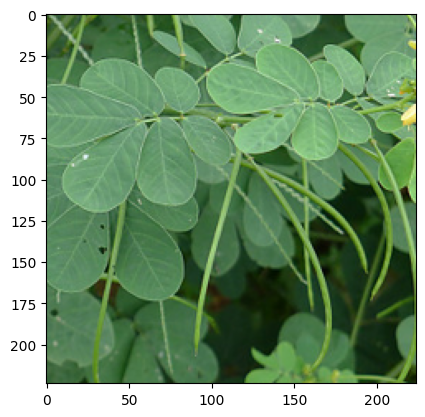

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/결명자.jpg')
imshow(image)

In [ ]:
# Implement the code to predict the class from an image file
# 이미지 파일에서 클래스를 예측하는 코드를 구현합니다.

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    # 클래스에 해당하는 확률 및 해당 확률의 인덱스
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('/content/결명자.jpg', model)   
print(probs)
print(classes)

[0.8940873146057129, 0.09254217892885208, 0.006546752527356148, 0.004006145987659693, 0.0013989972649142146]
['결명자', '은조롱', '호도', '칡', '나팔꽃']


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4352 (\N{HANGUL CHOSEONG KIYEOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4455 (\N{HANGUL JUNGSEONG YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4527 (\N{HANGUL JONGSEONG RIEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4358 (\N{HANGUL CHOSEONG MIEUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4540 (\N{HANGUL JONGSEONG IEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-pa

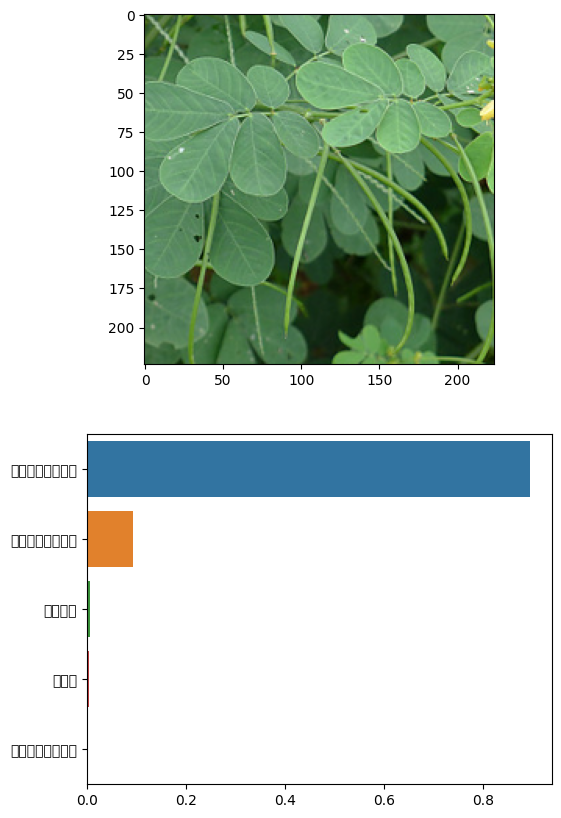

In [ ]:
# Display an image along with the top 5 classes

# Plot flower input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

#image = process_image('flowers/test/1/image_06743.jpg')
image = process_image('/content/결명자.jpg')


imshow(image, plot_1);

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=classes)

plt.show()

##스트림릿 페이지 제작 및 표출

In [1]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image


def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.FloatTensor)
    print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)

    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))

    if pil_image.mode == 'RGBA':
        pil_image = pil_image.convert('RGB')
    
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    
    #checkpoint = torch.load(filepath)
    checkpoint = torch.load(filepath,map_location ='cpu')
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 4096)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(4096, 128)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

model = load_checkpoint('체크포인트 경로')
#model = model.to("cuda")
st.title('약초 이미지 분류 웹 페이지')
file = st.file_uploader('약초 이미지를 올려주세요,', type=['jpg','png'])

#약초 이미지 분석결과와 약초 엑셀 데이터 연동

if file is None:
  st.text('이미지를 먼저 올려주세요.')
else:
  image = Image.open(file)
  st.image(image, use_column_width=True)
  image = process_image(file)
  probs, classes = predict(file, model)
  probs_percent = [p * 100 for p in probs]
  probs_str = [f'{p:.2f}%' for p in probs_percent]

  if float(probs_str[0].strip('%')) > 70:
      st.success(f"이 약초는 {classes[0]} 일 확률이 {probs_str[0]}입니다.")
      st.success(f"유사한 약초로는 {classes[1]} 일 확률이 {probs_str[1]}, {classes[2]} 일 확률이 {probs_str[2]}입니다. ")
      plant_df = pd.read_excel('약초정보 경로')

      # classes[0] 전처리
      import unicodedata
      pname = unicodedata.normalize('NFKC', classes[0].lower().strip())

      #plant_df['식물이름'] 전처리
      plant_df['식물이름'] = plant_df['식물이름'].str.strip().str.normalize('NFKC').str.lower()

     
      plant_df['식물이름'] = plant_df['식물이름'].str.strip()
      plant_info = plant_df.loc[plant_df["식물이름"].str.strip() == pname.strip()].transpose()


      # 약초 정보 파일에서 해당 약초에 대한 정보가 없는 경우
      if plant_info.empty:
          st.warning("정보가 없습니다.")
      # 일치하는 데이터가 있는 경우
      else:
          st.dataframe(plant_info, width=1500)

    
  else :
      st.warning("약초가 제대로 인식되지 않습니다. 다시 찍어주세요")

Writing app.py


##ngrok

In [ ]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [ ]:
!pip uninstall pyngrok

In [ ]:
!pip install pyngrok==4.1.1

In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token('ngrok 개인 토큰 입력')


In [ ]:
!nohup streamlit run app.py --server.port 80 &

nohup: appending output to 'nohup.out'


In [ ]:
url = ngrok.connect(port='80')
url

'http://aea1-34-73-5-128.ngrok-free.app'

In [ ]:
ngrok.kill() # 위에 쓴 기간 지난 url 죽이기